In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\patri\AppData\Local\Temp\ipykernel_2772\3470878462.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file handwritingData_1727517549959.svc:
0      0
1    145
2    250
3    335
4    430
Name: timestamp, dtype: int32




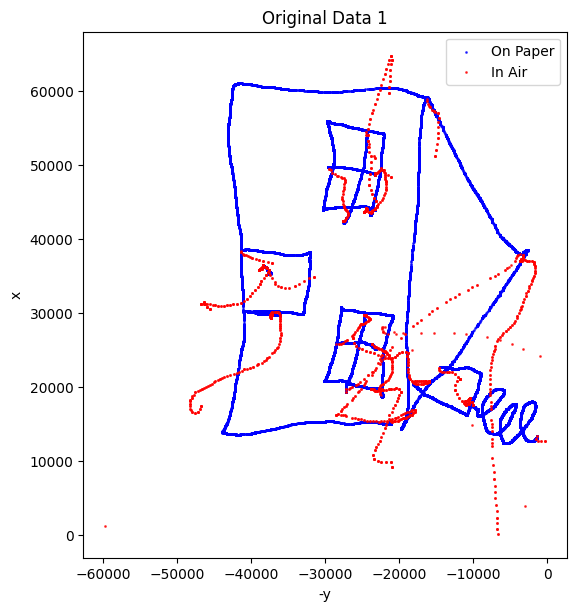

Number of processed files: 1
Average number of data points: 33643


In [2]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points

directory = '../uploads'  # Directory where the .svc files are stored
data_frames, processed_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

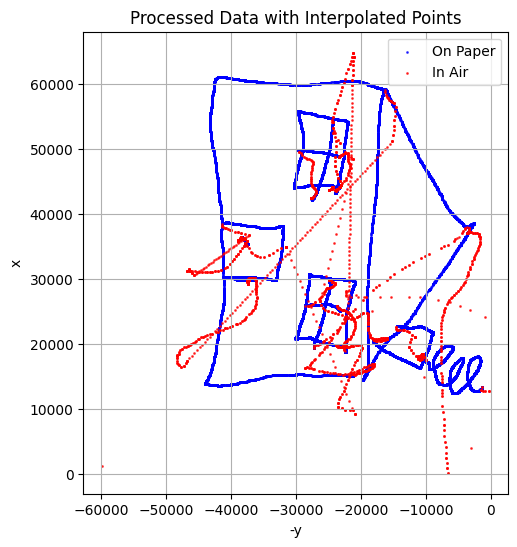

Number of processed files: 1
Average number of data points: 33854


In [3]:
# Assume the first processed DataFrame is the one we want to read
df = data_frames[0]  # Using the first DataFrame from the list returned by `upload_and_process_files`

# Convert the 'timestamp' column to numeric for calculations (if not already done)
df['timestamp'] = pd.to_numeric(df['timestamp'])

# Sort the DataFrame by timestamp (should already be sorted in the function)
df.sort_values('timestamp', inplace=True)

# Calculate the differences between consecutive timestamps (optional for gap finding)
df['time_diff'] = df['timestamp'].diff()

# Identify the indices where the time difference is greater than 30,000 milliseconds
gap_indices = df.index[df['time_diff'] > 30000].tolist()

# Create an empty list to hold the new rows
new_rows = []

# Fill in the gaps with 70 milliseconds intervals
for idx in gap_indices:
    # Check if the next index is valid
    if idx + 1 < len(df):
        # Get the current and next timestamps
        current_timestamp = df.at[idx, 'timestamp']
        next_timestamp = df.at[idx + 1, 'timestamp']
        
        # Calculate how many entries we need to fill in
        num_fill_entries = (next_timestamp - current_timestamp) // 20000

        # Generate the timestamps to fill the gap
        for i in range(1, num_fill_entries + 1):
            new_timestamp = current_timestamp + i * 70
            
            # Create a new row to fill in with NaN for x and y
            new_row = {
                'x': np.nan,  # Set x to NaN
                'y': np.nan,  # Set y to NaN
                'timestamp': new_timestamp,
                'pen_status': 0,        # You can set this to your desired value
                'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                'pressure': df.at[idx, 'pressure']  # Use the current pressure value
            }
            
            # Append the new row to the list of new rows
            new_rows.append(new_row)

# Create a DataFrame from the new rows
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the original DataFrame with the new rows DataFrame
df = pd.concat([df, new_rows_df], ignore_index=True)

# Sort the DataFrame by timestamp to maintain order
df.sort_values('timestamp', inplace=True)

# Reset index after sorting
df.reset_index(drop=True, inplace=True)

# Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
# Check for NaN entries before interpolation
if df[['x', 'y']].isnull().any().any():
    df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

# Drop the 'time_diff' column as it's no longer needed
df.drop(columns=['time_diff'], inplace=True)

# Plotting the result
plt.figure(figsize=(10, 6))


# Plot the rest of the data
on_paper = df[df['pen_status'] == 1]
in_air = df[df['pen_status'] == 0]
plt.scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
plt.scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')


# Labels and titles
plt.title('Processed Data with Interpolated Points')
plt.xlabel('-y')
plt.ylabel('x')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)

# Show the plot
plt.show()

processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                    for df, scaler in zip(data_frames, scalers)]
avg_data_points = df.shape[0]

print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [4]:
import os

# Define a valid directory path where you want to save the file
output_dir = './imputed/'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the full file path including the filename
output_path = os.path.join(output_dir, 'processed_data.svc')

# Save the DataFrame as a space-separated .svc file
df.to_csv(output_path, sep=' ', index=False, header=False)

print(f"File saved to: {output_path}")


File saved to: ./imputed/processed_data.svc


Modified timestamps for file processed_data.svc:

C:\Users\patri\AppData\Local\Temp\ipykernel_2772\657295717.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)



0        0
1      105
2      190
3      285
4    18635
Name: timestamp, dtype: int32




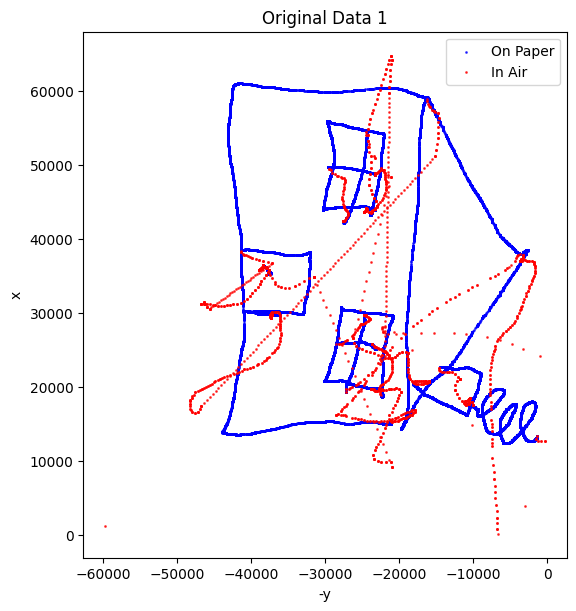

Number of processed files: 1
Average number of data points: 33853


In [5]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points

directory = './imputed'  # Directory where the .svc files are stored
data_frames, processed_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [6]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # Changed to 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # Changed to 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)

# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


latent_dim = 64
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
# Cell 4 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, variability=0.05, latent_variability=1.0):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        # Select input data sequentially, cycling through if necessary
        selected_data = processed_data[i % num_input_files]
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        
        # Increase variability in the latent space
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/200: 100%|██████████| 529/529 [00:05<00:00, 102.36batch/s, Generator Loss=0.148, Reconstruction Loss=0.148, KL Loss=6.42]  


Epoch 1: Generator Loss = 0.135330, Reconstruction Loss = 0.135327, KL Divergence Loss = 3.496193
NRMSE = 0.228694


Epoch 2/200: 100%|██████████| 529/529 [00:01<00:00, 279.77batch/s, Generator Loss=0.142, Reconstruction Loss=0.142, KL Loss=9.8]    


Epoch 2: Generator Loss = 0.084212, Reconstruction Loss = 0.084204, KL Divergence Loss = 8.374971
NRMSE = 0.232840


Epoch 3/200: 100%|██████████| 529/529 [00:01<00:00, 313.51batch/s, Generator Loss=0.151, Reconstruction Loss=0.151, KL Loss=10.6]   


Epoch 3: Generator Loss = 0.079573, Reconstruction Loss = 0.079564, KL Divergence Loss = 9.686044
NRMSE = 0.229072


Epoch 4/200: 100%|██████████| 529/529 [00:01<00:00, 358.73batch/s, Generator Loss=0.154, Reconstruction Loss=0.154, KL Loss=10.4]   


Epoch 4: Generator Loss = 0.078758, Reconstruction Loss = 0.078748, KL Divergence Loss = 9.602641
NRMSE = 0.227218


Epoch 5/200: 100%|██████████| 529/529 [00:02<00:00, 254.39batch/s, Generator Loss=0.157, Reconstruction Loss=0.157, KL Loss=10.2]   


Epoch 5: Generator Loss = 0.078676, Reconstruction Loss = 0.078666, KL Divergence Loss = 9.413387
NRMSE = 0.227457


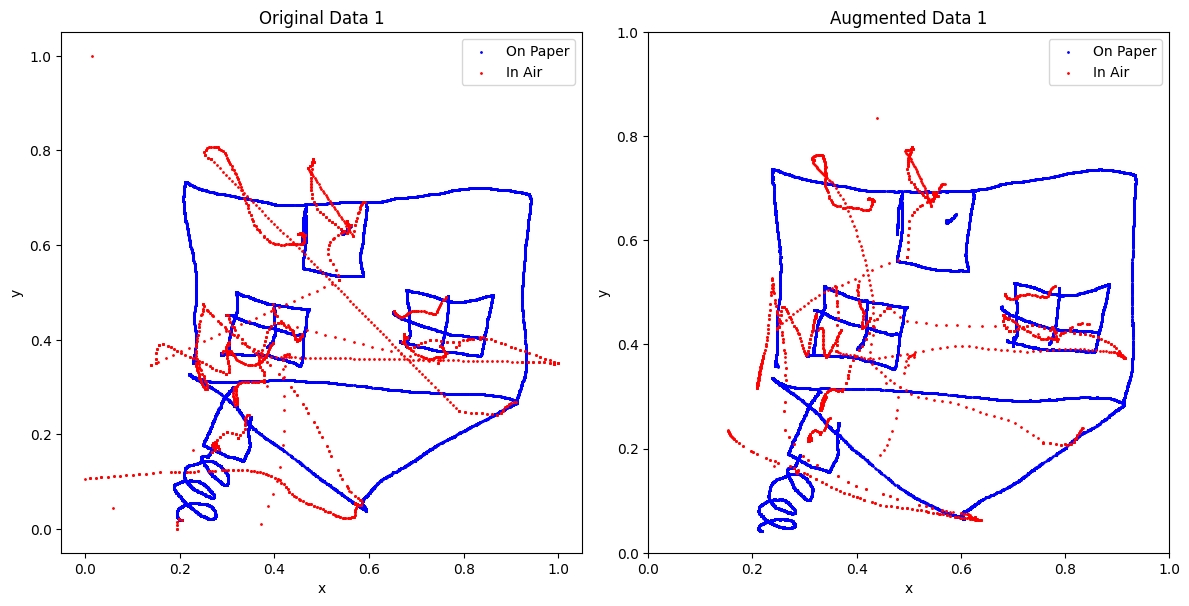

Epoch 6/200: 100%|██████████| 529/529 [00:02<00:00, 242.28batch/s, Generator Loss=0.146, Reconstruction Loss=0.146, KL Loss=9.26]   


Epoch 6: Generator Loss = 0.078590, Reconstruction Loss = 0.078582, KL Divergence Loss = 8.901472
NRMSE = 0.227817


Epoch 7/200: 100%|██████████| 529/529 [00:03<00:00, 141.69batch/s, Generator Loss=0.00016, Reconstruction Loss=0.000153, KL Loss=6.96] 


Epoch 7: Generator Loss = 0.004872, Reconstruction Loss = 0.004865, KL Divergence Loss = 6.625011
NRMSE = 0.232263


Epoch 8/200: 100%|██████████| 529/529 [00:02<00:00, 177.76batch/s, Generator Loss=0.000151, Reconstruction Loss=0.000144, KL Loss=7.34]


Epoch 8: Generator Loss = 0.000161, Reconstruction Loss = 0.000155, KL Divergence Loss = 6.738479
NRMSE = 0.233817


Epoch 9/200: 100%|██████████| 529/529 [00:02<00:00, 234.82batch/s, Generator Loss=4.38e-5, Reconstruction Loss=3.65e-5, KL Loss=7.35]  


Epoch 9: Generator Loss = 0.000106, Reconstruction Loss = 0.000099, KL Divergence Loss = 6.860433
NRMSE = 0.234201


Epoch 10/200: 100%|██████████| 529/529 [00:02<00:00, 180.56batch/s, Generator Loss=8.39e-5, Reconstruction Loss=7.65e-5, KL Loss=7.4]   


Epoch 10: Generator Loss = 0.000074, Reconstruction Loss = 0.000067, KL Divergence Loss = 6.946148
NRMSE = 0.233684


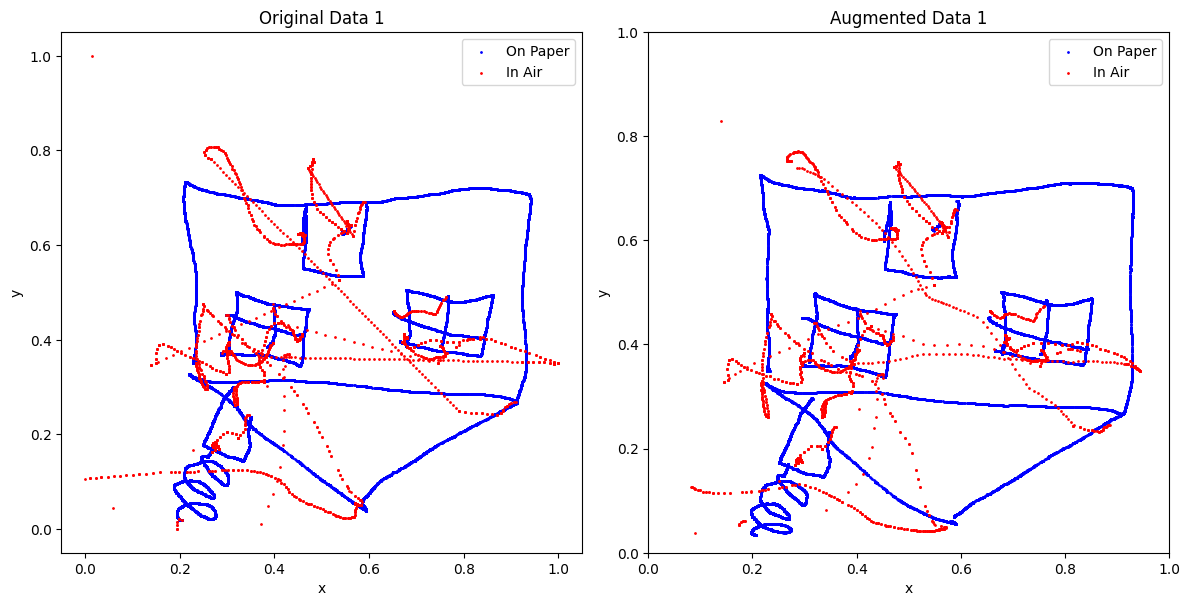

Epoch 11/200: 100%|██████████| 529/529 [00:03<00:00, 175.41batch/s, Generator Loss=0.000111, Reconstruction Loss=0.000104, KL Loss=7.11]


Epoch 11: Generator Loss = 0.000072, Reconstruction Loss = 0.000065, KL Divergence Loss = 6.852232
NRMSE = 0.234964


Epoch 12/200: 100%|██████████| 529/529 [00:02<00:00, 204.27batch/s, Generator Loss=3e-5, Reconstruction Loss=2.31e-5, KL Loss=6.96]     


Epoch 12: Generator Loss = 0.000081, Reconstruction Loss = 0.000075, KL Divergence Loss = 6.560648
NRMSE = 0.235957


Epoch 13/200: 100%|██████████| 529/529 [00:01<00:00, 277.93batch/s, Generator Loss=5.96e-5, Reconstruction Loss=5.29e-5, KL Loss=6.64]  


Epoch 13: Generator Loss = 0.000052, Reconstruction Loss = 0.000046, KL Divergence Loss = 6.533037
NRMSE = 0.236273


Epoch 14/200: 100%|██████████| 529/529 [00:02<00:00, 226.16batch/s, Generator Loss=7.95e-5, Reconstruction Loss=7.29e-5, KL Loss=6.55]  


Epoch 14: Generator Loss = 0.000061, Reconstruction Loss = 0.000055, KL Divergence Loss = 6.377314
NRMSE = 0.237376


Epoch 15/200: 100%|██████████| 529/529 [00:02<00:00, 260.85batch/s, Generator Loss=6.34e-5, Reconstruction Loss=5.69e-5, KL Loss=6.5]   


Epoch 15: Generator Loss = 0.000049, Reconstruction Loss = 0.000043, KL Divergence Loss = 6.249909
NRMSE = 0.237852


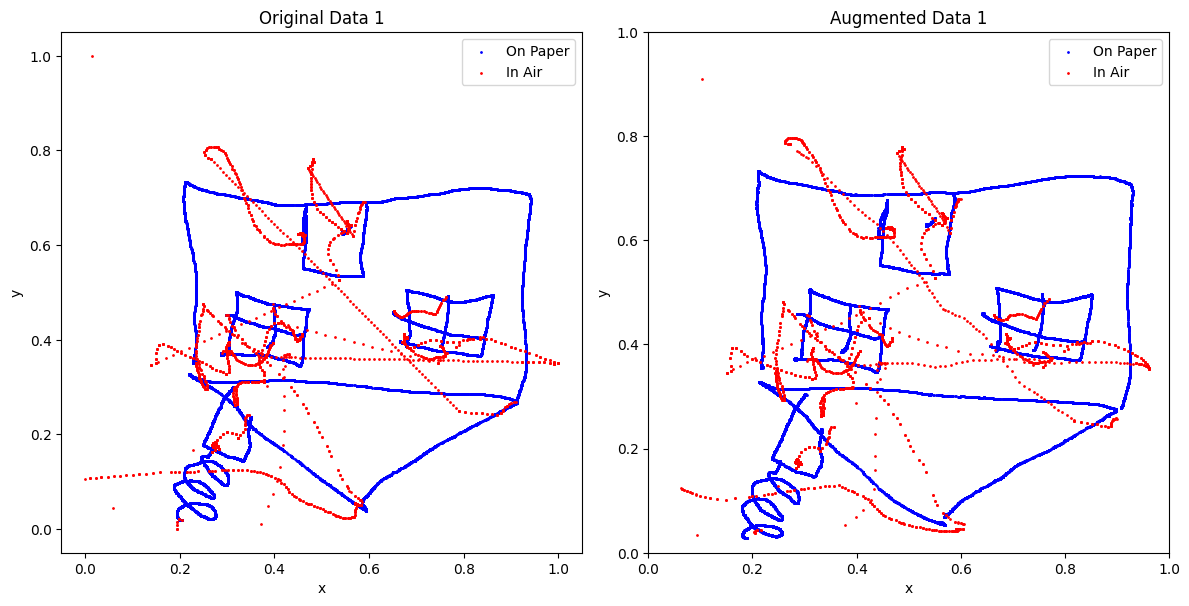

Epoch 16/200: 100%|██████████| 529/529 [00:01<00:00, 312.08batch/s, Generator Loss=2.13e-5, Reconstruction Loss=1.5e-5, KL Loss=6.3]    


Epoch 16: Generator Loss = 0.000059, Reconstruction Loss = 0.000053, KL Divergence Loss = 6.058241
NRMSE = 0.237715


Epoch 17/200: 100%|██████████| 529/529 [00:02<00:00, 221.14batch/s, Generator Loss=2.02e-5, Reconstruction Loss=1.42e-5, KL Loss=6.03]  


Epoch 17: Generator Loss = 0.000057, Reconstruction Loss = 0.000051, KL Divergence Loss = 5.905902
NRMSE = 0.238553


Epoch 18/200: 100%|██████████| 529/529 [00:02<00:00, 249.62batch/s, Generator Loss=5.77e-5, Reconstruction Loss=5.17e-5, KL Loss=6.01]  


Epoch 18: Generator Loss = 0.000038, Reconstruction Loss = 0.000032, KL Divergence Loss = 5.820064
NRMSE = 0.238870


Epoch 19/200: 100%|██████████| 529/529 [00:01<00:00, 278.08batch/s, Generator Loss=2.25e-5, Reconstruction Loss=1.65e-5, KL Loss=6.05]  


Epoch 19: Generator Loss = 0.000050, Reconstruction Loss = 0.000044, KL Divergence Loss = 5.714235
NRMSE = 0.238414


Epoch 20/200: 100%|██████████| 529/529 [00:15<00:00, 33.37batch/s, Generator Loss=-0.139, Reconstruction Loss=8.54e-5, KL Loss=5.71] 


LSTM training at epoch 20: Discriminator Loss = [1.3643298]
Epoch 20: Generator Loss = -0.138573, Reconstruction Loss = 0.000080, KL Divergence Loss = 5.499292
NRMSE = 0.237267


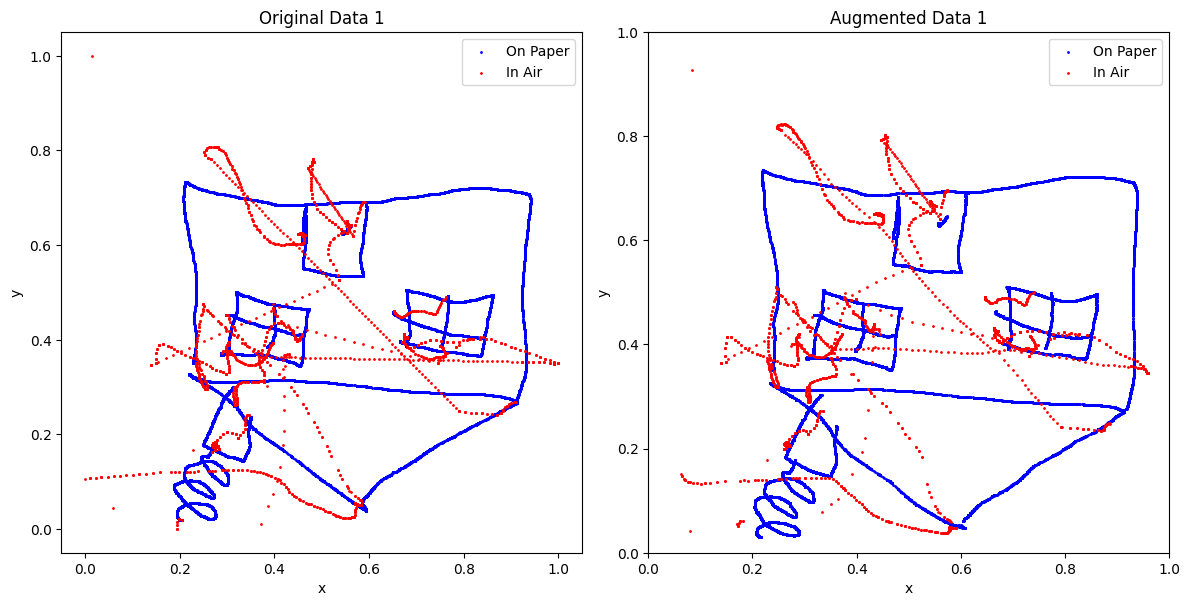

Epoch 21/200: 100%|██████████| 529/529 [00:01<00:00, 389.37batch/s, Generator Loss=5.07e-5, Reconstruction Loss=4.49e-5, KL Loss=5.79]  


Epoch 21: Generator Loss = 0.000027, Reconstruction Loss = 0.000021, KL Divergence Loss = 5.548438
NRMSE = 0.238269


Epoch 22/200: 100%|██████████| 529/529 [00:01<00:00, 401.74batch/s, Generator Loss=3.69e-5, Reconstruction Loss=3.13e-5, KL Loss=5.67]  


Epoch 22: Generator Loss = 0.000036, Reconstruction Loss = 0.000031, KL Divergence Loss = 5.468225
NRMSE = 0.238649


Epoch 23/200: 100%|██████████| 529/529 [00:01<00:00, 371.08batch/s, Generator Loss=3.64e-5, Reconstruction Loss=3.09e-5, KL Loss=5.51]  


Epoch 23: Generator Loss = 0.000038, Reconstruction Loss = 0.000032, KL Divergence Loss = 5.389241
NRMSE = 0.238413


Epoch 24/200: 100%|██████████| 529/529 [00:01<00:00, 422.17batch/s, Generator Loss=6.21e-5, Reconstruction Loss=5.66e-5, KL Loss=5.49] 


Epoch 24: Generator Loss = 0.000033, Reconstruction Loss = 0.000028, KL Divergence Loss = 5.321324
NRMSE = 0.238905


Epoch 25/200: 100%|██████████| 529/529 [00:01<00:00, 412.73batch/s, Generator Loss=2.61e-5, Reconstruction Loss=2.07e-5, KL Loss=5.46] 


Epoch 25: Generator Loss = 0.000033, Reconstruction Loss = 0.000028, KL Divergence Loss = 5.278021
NRMSE = 0.238599


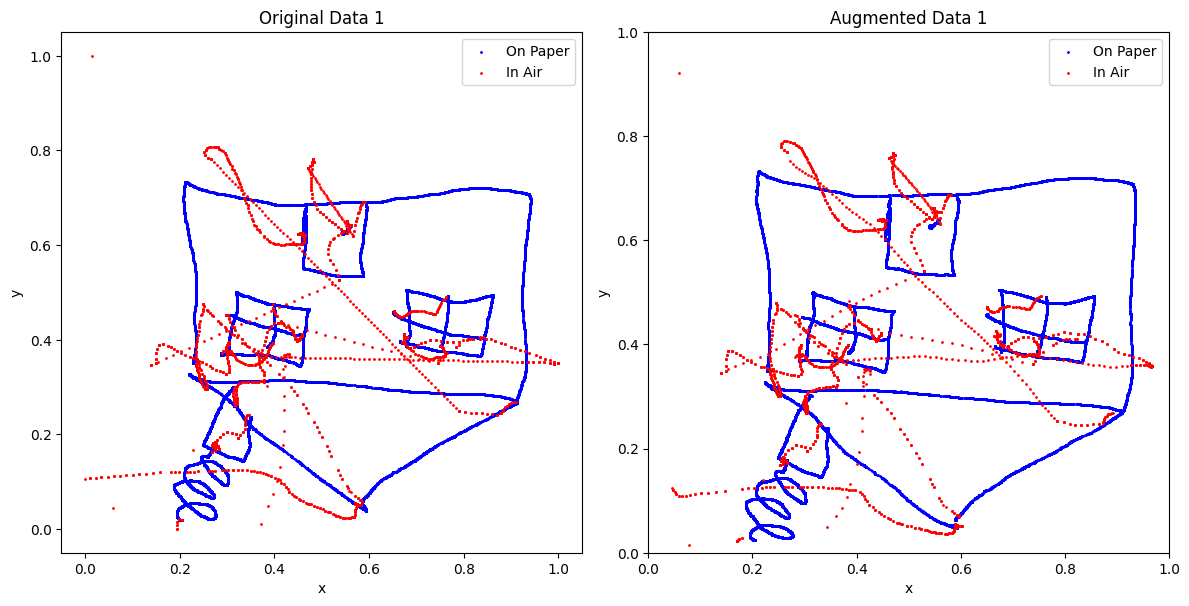

Epoch 26/200: 100%|██████████| 529/529 [00:01<00:00, 398.17batch/s, Generator Loss=1.54e-5, Reconstruction Loss=1e-5, KL Loss=5.39]     


Epoch 26: Generator Loss = 0.000034, Reconstruction Loss = 0.000029, KL Divergence Loss = 5.211269
NRMSE = 0.239164


Epoch 27/200: 100%|██████████| 529/529 [00:01<00:00, 370.37batch/s, Generator Loss=3.29e-5, Reconstruction Loss=2.76e-5, KL Loss=5.33] 


Epoch 27: Generator Loss = 0.000029, Reconstruction Loss = 0.000024, KL Divergence Loss = 5.165330
NRMSE = 0.240400


Epoch 28/200: 100%|██████████| 529/529 [00:01<00:00, 347.48batch/s, Generator Loss=8.02e-5, Reconstruction Loss=7.49e-5, KL Loss=5.23]  


Epoch 28: Generator Loss = 0.000057, Reconstruction Loss = 0.000052, KL Divergence Loss = 5.052218
NRMSE = 0.239535


Epoch 29/200: 100%|██████████| 529/529 [00:01<00:00, 402.03batch/s, Generator Loss=1.48e-5, Reconstruction Loss=9.62e-6, KL Loss=5.16] 


Epoch 29: Generator Loss = 0.000025, Reconstruction Loss = 0.000020, KL Divergence Loss = 5.077868
NRMSE = 0.241166


Epoch 30/200: 100%|██████████| 529/529 [00:08<00:00, 59.50batch/s, Generator Loss=-0.139, Reconstruction Loss=8.58e-5, KL Loss=5.03] 


LSTM training at epoch 30: Discriminator Loss = [1.3080862]
Epoch 30: Generator Loss = -0.138772, Reconstruction Loss = 0.000088, KL Divergence Loss = 4.926310
NRMSE = 0.239316


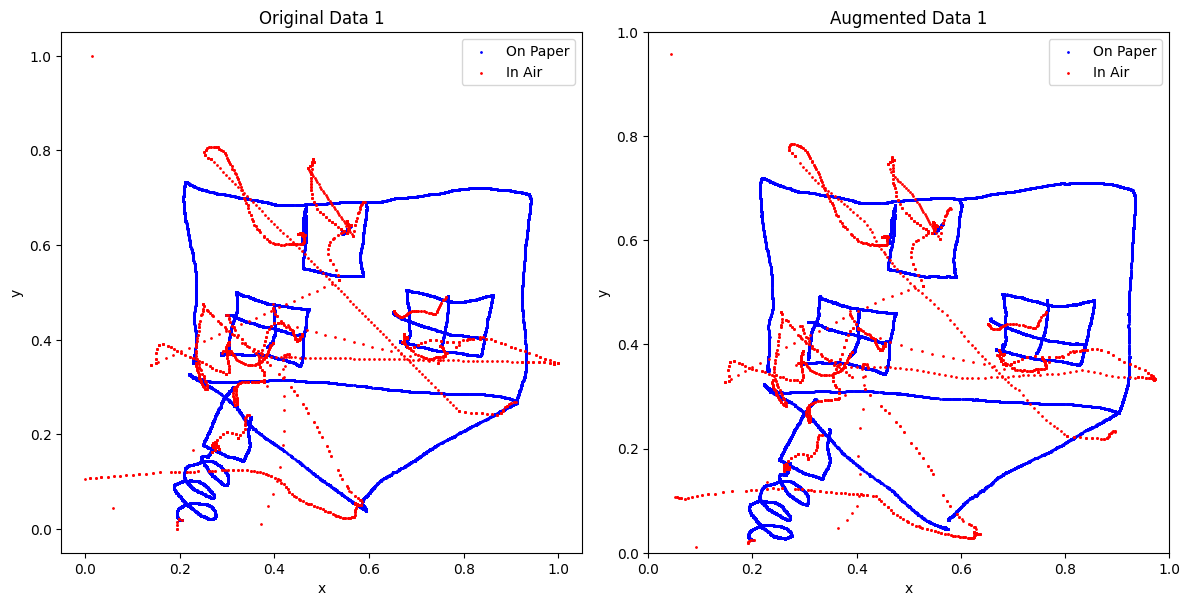

Epoch 31/200: 100%|██████████| 529/529 [00:01<00:00, 320.79batch/s, Generator Loss=1.4e-5, Reconstruction Loss=8.92e-6, KL Loss=5.11] 


Epoch 31: Generator Loss = 0.000017, Reconstruction Loss = 0.000012, KL Divergence Loss = 4.985402
NRMSE = 0.239851


Epoch 32/200: 100%|██████████| 529/529 [00:01<00:00, 374.10batch/s, Generator Loss=1.76e-5, Reconstruction Loss=1.26e-5, KL Loss=5.04] 


Epoch 32: Generator Loss = 0.000020, Reconstruction Loss = 0.000015, KL Divergence Loss = 4.950157
NRMSE = 0.240661


Epoch 33/200: 100%|██████████| 529/529 [00:01<00:00, 370.93batch/s, Generator Loss=1.32e-5, Reconstruction Loss=8.25e-6, KL Loss=4.96]  


Epoch 33: Generator Loss = 0.000027, Reconstruction Loss = 0.000022, KL Divergence Loss = 4.867257
NRMSE = 0.241318


Epoch 34/200: 100%|██████████| 529/529 [00:01<00:00, 322.34batch/s, Generator Loss=2.09e-5, Reconstruction Loss=1.59e-5, KL Loss=5.05] 


Epoch 34: Generator Loss = 0.000022, Reconstruction Loss = 0.000017, KL Divergence Loss = 4.869267
NRMSE = 0.242740


Epoch 35/200: 100%|██████████| 529/529 [00:01<00:00, 293.41batch/s, Generator Loss=3.35e-5, Reconstruction Loss=2.86e-5, KL Loss=4.97]  


Epoch 35: Generator Loss = 0.000024, Reconstruction Loss = 0.000019, KL Divergence Loss = 4.832699
NRMSE = 0.240189


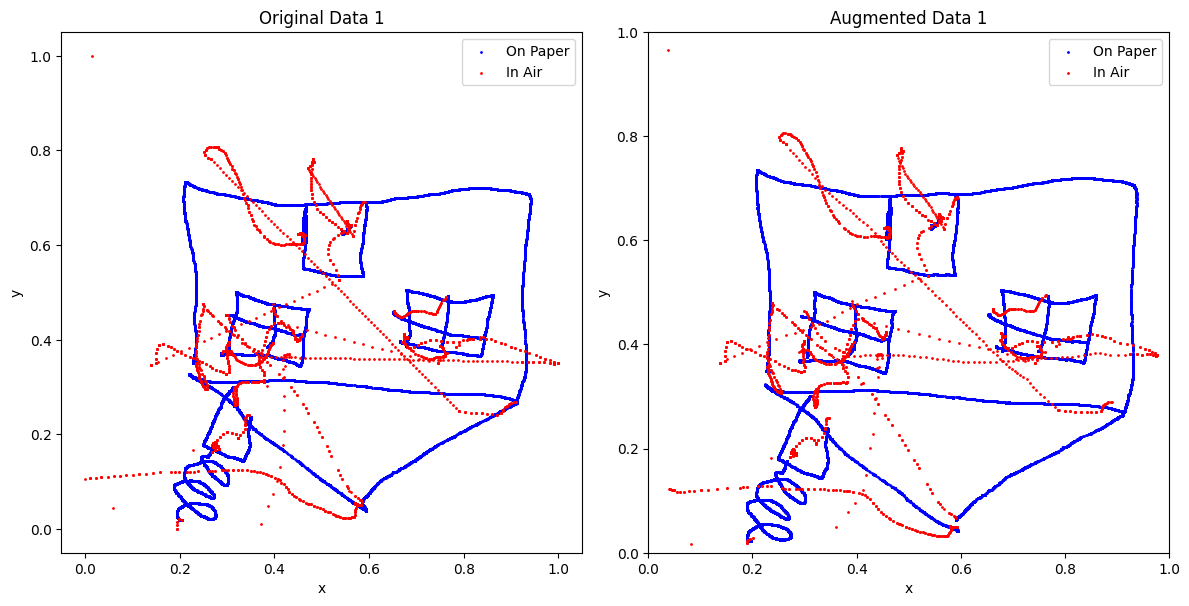

Epoch 36/200: 100%|██████████| 529/529 [00:01<00:00, 372.42batch/s, Generator Loss=1.92e-5, Reconstruction Loss=1.43e-5, KL Loss=4.84]


Epoch 36: Generator Loss = 0.000018, Reconstruction Loss = 0.000013, KL Divergence Loss = 4.835034
NRMSE = 0.240273


Epoch 37/200: 100%|██████████| 529/529 [00:01<00:00, 387.04batch/s, Generator Loss=1.32e-5, Reconstruction Loss=8.42e-6, KL Loss=4.82]  


Epoch 37: Generator Loss = 0.000026, Reconstruction Loss = 0.000022, KL Divergence Loss = 4.785342
NRMSE = 0.241409


Epoch 38/200: 100%|██████████| 529/529 [00:01<00:00, 376.81batch/s, Generator Loss=1.86e-5, Reconstruction Loss=1.38e-5, KL Loss=4.76]


Epoch 38: Generator Loss = 0.000019, Reconstruction Loss = 0.000014, KL Divergence Loss = 4.777879
NRMSE = 0.241657


Epoch 39/200: 100%|██████████| 529/529 [00:01<00:00, 330.90batch/s, Generator Loss=2.08e-5, Reconstruction Loss=1.59e-5, KL Loss=4.82] 


Epoch 39: Generator Loss = 0.000026, Reconstruction Loss = 0.000021, KL Divergence Loss = 4.720163
NRMSE = 0.240543


Epoch 40/200: 100%|██████████| 529/529 [00:11<00:00, 45.99batch/s, Generator Loss=-0.139, Reconstruction Loss=0.000113, KL Loss=4.72]


LSTM training at epoch 40: Discriminator Loss = [1.2706398]
Epoch 40: Generator Loss = -0.139367, Reconstruction Loss = 0.000135, KL Divergence Loss = 4.595232
NRMSE = 0.238684


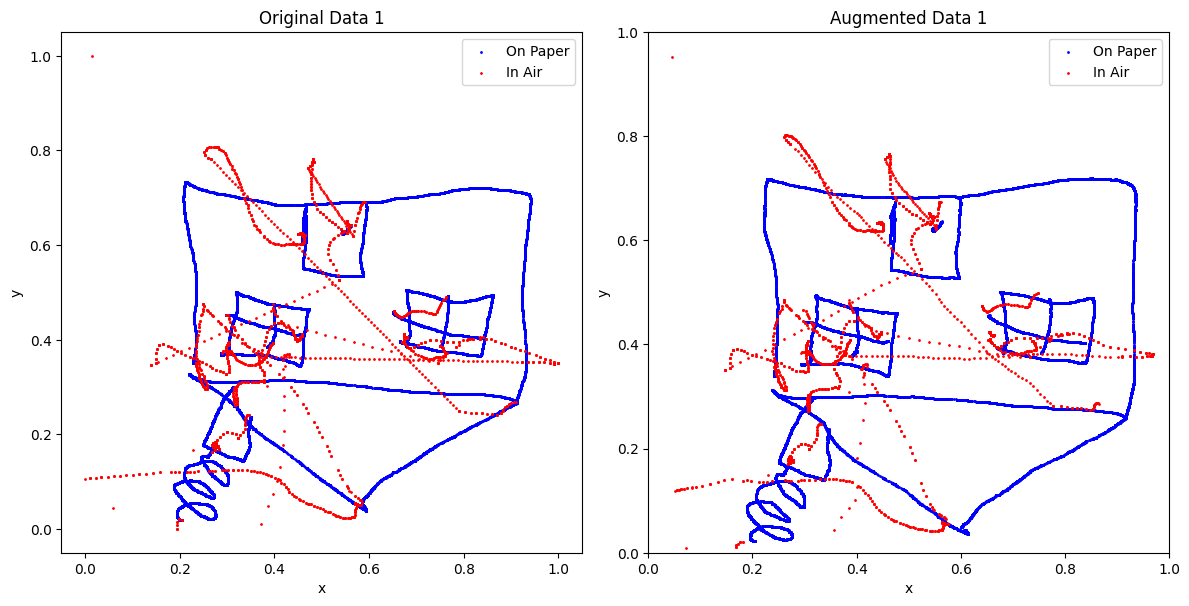

Epoch 41/200: 100%|██████████| 529/529 [00:02<00:00, 203.01batch/s, Generator Loss=8.95e-6, Reconstruction Loss=4.09e-6, KL Loss=4.86]


Epoch 41: Generator Loss = 0.000016, Reconstruction Loss = 0.000012, KL Divergence Loss = 4.660932
NRMSE = 0.241604


Epoch 42/200: 100%|██████████| 529/529 [00:02<00:00, 258.68batch/s, Generator Loss=1.21e-5, Reconstruction Loss=7.34e-6, KL Loss=4.76]


Epoch 42: Generator Loss = 0.000013, Reconstruction Loss = 0.000008, KL Divergence Loss = 4.683026
NRMSE = 0.242141


Epoch 43/200: 100%|██████████| 529/529 [00:02<00:00, 246.51batch/s, Generator Loss=1.01e-5, Reconstruction Loss=5.43e-6, KL Loss=4.64] 


Epoch 43: Generator Loss = 0.000020, Reconstruction Loss = 0.000015, KL Divergence Loss = 4.625217
NRMSE = 0.242603


Epoch 44/200: 100%|██████████| 529/529 [00:02<00:00, 230.52batch/s, Generator Loss=1.62e-5, Reconstruction Loss=1.16e-5, KL Loss=4.62]  


Epoch 44: Generator Loss = 0.000017, Reconstruction Loss = 0.000013, KL Divergence Loss = 4.606649
NRMSE = 0.243341


Epoch 45/200: 100%|██████████| 529/529 [00:01<00:00, 304.35batch/s, Generator Loss=9.79e-6, Reconstruction Loss=5.29e-6, KL Loss=4.5] 


Epoch 45: Generator Loss = 0.000018, Reconstruction Loss = 0.000013, KL Divergence Loss = 4.591194
NRMSE = 0.242840


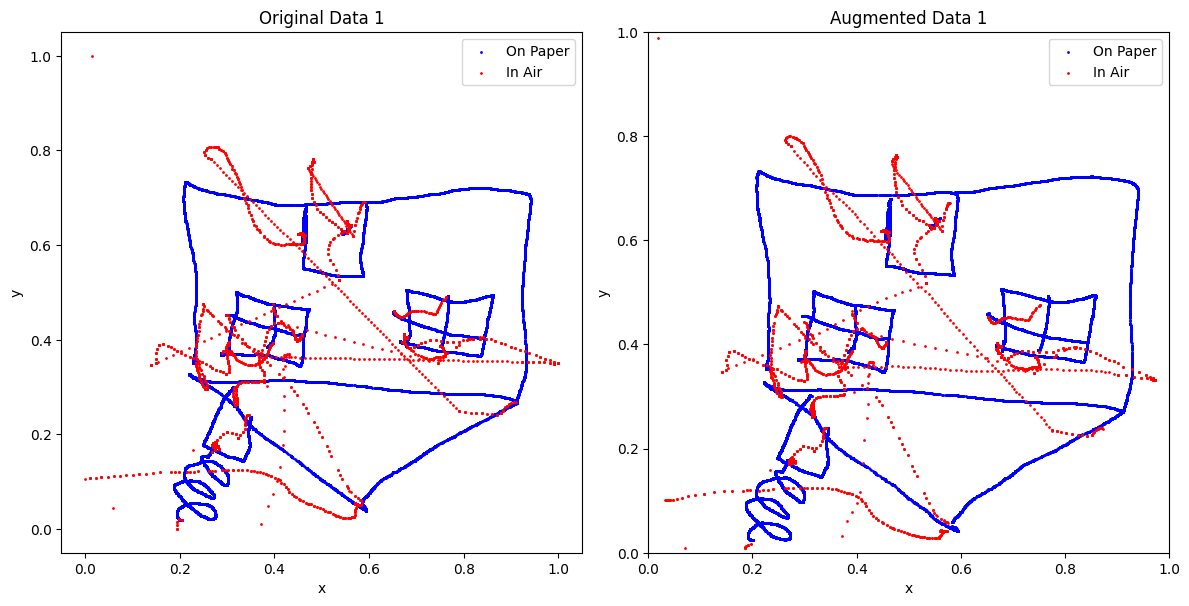

Epoch 46/200: 100%|██████████| 529/529 [00:02<00:00, 238.16batch/s, Generator Loss=8.51e-6, Reconstruction Loss=3.96e-6, KL Loss=4.55]


Epoch 46: Generator Loss = 0.000017, Reconstruction Loss = 0.000012, KL Divergence Loss = 4.570913
NRMSE = 0.243098


Epoch 47/200: 100%|██████████| 529/529 [00:02<00:00, 215.62batch/s, Generator Loss=1.58e-5, Reconstruction Loss=1.13e-5, KL Loss=4.54]  


Epoch 47: Generator Loss = 0.000019, Reconstruction Loss = 0.000015, KL Divergence Loss = 4.567315
NRMSE = 0.244263


Epoch 48/200: 100%|██████████| 529/529 [00:02<00:00, 222.25batch/s, Generator Loss=1.25e-5, Reconstruction Loss=7.93e-6, KL Loss=4.58]


Epoch 48: Generator Loss = 0.000017, Reconstruction Loss = 0.000013, KL Divergence Loss = 4.554982
NRMSE = 0.244044


Epoch 49/200: 100%|██████████| 529/529 [00:01<00:00, 300.13batch/s, Generator Loss=1.07e-5, Reconstruction Loss=6.12e-6, KL Loss=4.57] 


Epoch 49: Generator Loss = 0.000017, Reconstruction Loss = 0.000012, KL Divergence Loss = 4.527935
NRMSE = 0.244340


Epoch 50/200: 100%|██████████| 529/529 [00:12<00:00, 42.40batch/s, Generator Loss=-0.14, Reconstruction Loss=0.000187, KL Loss=4.67] 


LSTM training at epoch 50: Discriminator Loss = [1.1895584]
Epoch 50: Generator Loss = -0.140516, Reconstruction Loss = 0.000187, KL Divergence Loss = 4.430479
NRMSE = 0.240518


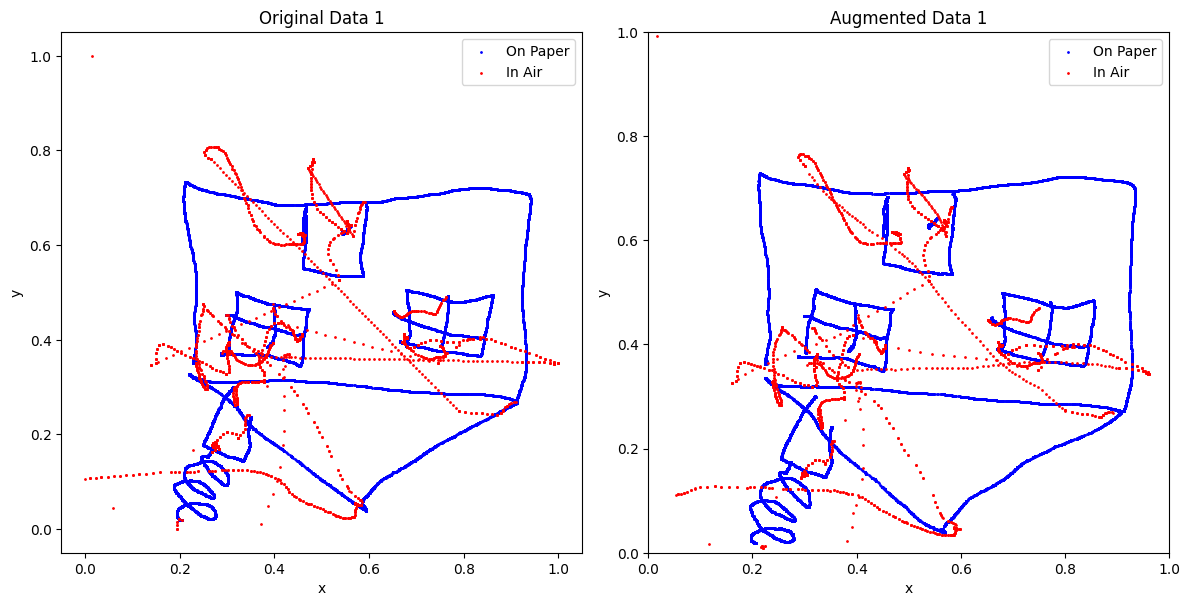

Epoch 51/200: 100%|██████████| 529/529 [00:01<00:00, 297.46batch/s, Generator Loss=1.25e-5, Reconstruction Loss=8e-6, KL Loss=4.5]     


Epoch 51: Generator Loss = 0.000018, Reconstruction Loss = 0.000014, KL Divergence Loss = 4.546110
NRMSE = 0.242503


Epoch 52/200: 100%|██████████| 529/529 [00:01<00:00, 269.63batch/s, Generator Loss=2.11e-5, Reconstruction Loss=1.65e-5, KL Loss=4.54]


Epoch 52: Generator Loss = 0.000012, Reconstruction Loss = 0.000007, KL Divergence Loss = 4.514760
NRMSE = 0.243294


Epoch 53/200: 100%|██████████| 529/529 [00:01<00:00, 276.40batch/s, Generator Loss=9.74e-6, Reconstruction Loss=5.29e-6, KL Loss=4.45]


Epoch 53: Generator Loss = 0.000014, Reconstruction Loss = 0.000010, KL Divergence Loss = 4.460832
NRMSE = 0.243560


Epoch 54/200: 100%|██████████| 529/529 [00:01<00:00, 282.15batch/s, Generator Loss=2.31e-5, Reconstruction Loss=1.86e-5, KL Loss=4.48]  


Epoch 54: Generator Loss = 0.000019, Reconstruction Loss = 0.000014, KL Divergence Loss = 4.431412
NRMSE = 0.243693


Epoch 55/200: 100%|██████████| 529/529 [00:01<00:00, 293.00batch/s, Generator Loss=1.15e-5, Reconstruction Loss=7.07e-6, KL Loss=4.47] 


Epoch 55: Generator Loss = 0.000014, Reconstruction Loss = 0.000010, KL Divergence Loss = 4.434135
NRMSE = 0.243054


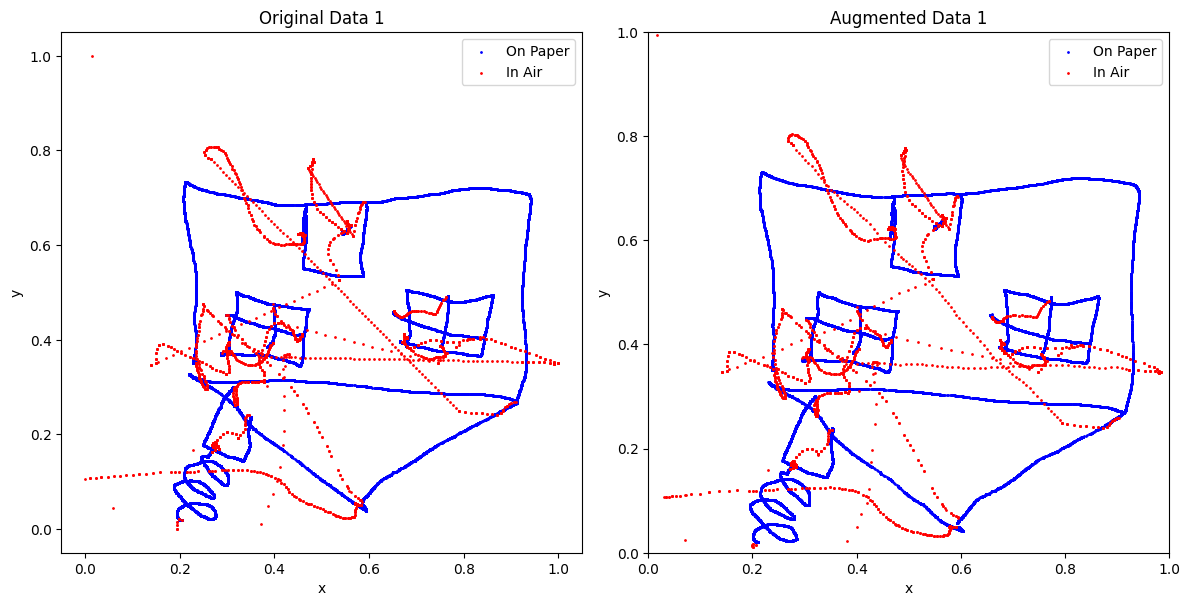

Epoch 56/200: 100%|██████████| 529/529 [00:01<00:00, 303.09batch/s, Generator Loss=2.26e-5, Reconstruction Loss=1.82e-5, KL Loss=4.39]


Epoch 56: Generator Loss = 0.000017, Reconstruction Loss = 0.000012, KL Divergence Loss = 4.407127
NRMSE = 0.244121


Epoch 57/200: 100%|██████████| 529/529 [00:01<00:00, 296.92batch/s, Generator Loss=1.29e-5, Reconstruction Loss=8.51e-6, KL Loss=4.39]  


Epoch 57: Generator Loss = 0.000015, Reconstruction Loss = 0.000010, KL Divergence Loss = 4.413339
NRMSE = 0.244656


Epoch 58/200: 100%|██████████| 529/529 [00:01<00:00, 270.50batch/s, Generator Loss=1.73e-5, Reconstruction Loss=1.3e-5, KL Loss=4.33] 


Epoch 58: Generator Loss = 0.000014, Reconstruction Loss = 0.000010, KL Divergence Loss = 4.391272
NRMSE = 0.244614


Epoch 59/200: 100%|██████████| 529/529 [00:01<00:00, 304.99batch/s, Generator Loss=7.96e-6, Reconstruction Loss=3.53e-6, KL Loss=4.43] 


Epoch 59: Generator Loss = 0.000022, Reconstruction Loss = 0.000018, KL Divergence Loss = 4.381845
NRMSE = 0.245568


Epoch 60/200: 100%|██████████| 529/529 [00:10<00:00, 52.16batch/s, Generator Loss=-0.141, Reconstruction Loss=0.000261, KL Loss=4.4] 


LSTM training at epoch 60: Discriminator Loss = [1.155431]
Epoch 60: Generator Loss = -0.142288, Reconstruction Loss = 0.000242, KL Divergence Loss = 4.317878
NRMSE = 0.247921


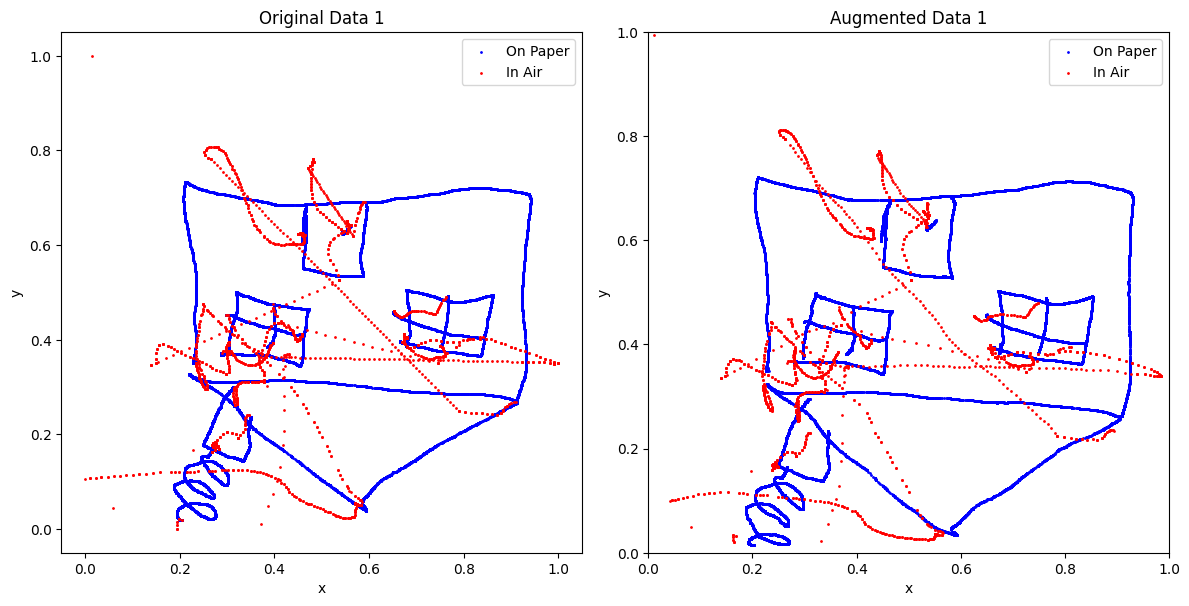

Epoch 61/200: 100%|██████████| 529/529 [00:02<00:00, 194.72batch/s, Generator Loss=8.95e-6, Reconstruction Loss=4.5e-6, KL Loss=4.45]  


Epoch 61: Generator Loss = 0.000016, Reconstruction Loss = 0.000011, KL Divergence Loss = 4.424503
NRMSE = 0.248762


Epoch 62/200: 100%|██████████| 529/529 [00:01<00:00, 265.68batch/s, Generator Loss=1.01e-5, Reconstruction Loss=5.66e-6, KL Loss=4.45]


Epoch 62: Generator Loss = 0.000009, Reconstruction Loss = 0.000005, KL Divergence Loss = 4.405022
NRMSE = 0.248122


Epoch 63/200: 100%|██████████| 529/529 [00:01<00:00, 278.38batch/s, Generator Loss=8.6e-6, Reconstruction Loss=4.16e-6, KL Loss=4.44] 


Epoch 63: Generator Loss = 0.000011, Reconstruction Loss = 0.000007, KL Divergence Loss = 4.359129
NRMSE = 0.247600


Epoch 64/200: 100%|██████████| 529/529 [00:01<00:00, 274.66batch/s, Generator Loss=1.32e-5, Reconstruction Loss=8.79e-6, KL Loss=4.37] 


Epoch 64: Generator Loss = 0.000015, Reconstruction Loss = 0.000010, KL Divergence Loss = 4.328769
NRMSE = 0.247326


Epoch 65/200: 100%|██████████| 529/529 [00:01<00:00, 290.24batch/s, Generator Loss=1.25e-5, Reconstruction Loss=8.23e-6, KL Loss=4.24]


Epoch 65: Generator Loss = 0.000013, Reconstruction Loss = 0.000008, KL Divergence Loss = 4.328851
NRMSE = 0.245461


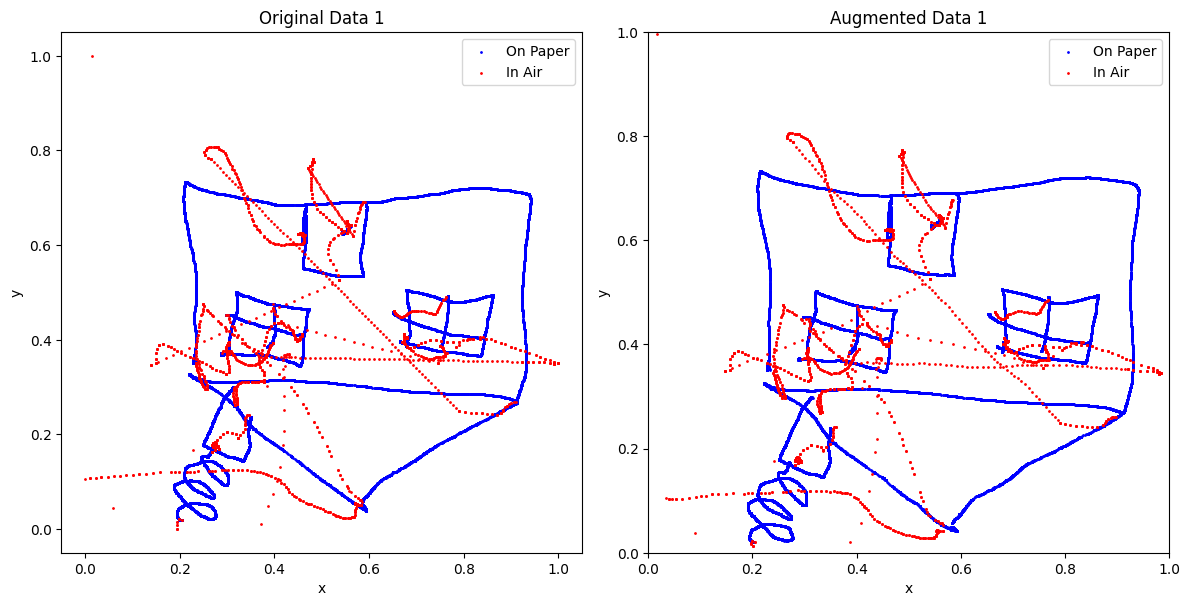

Epoch 66/200: 100%|██████████| 529/529 [00:02<00:00, 245.91batch/s, Generator Loss=1.15e-5, Reconstruction Loss=7.12e-6, KL Loss=4.36]


Epoch 66: Generator Loss = 0.000014, Reconstruction Loss = 0.000010, KL Divergence Loss = 4.317181
NRMSE = 0.246485


Epoch 67/200: 100%|██████████| 529/529 [00:01<00:00, 320.05batch/s, Generator Loss=7.1e-6, Reconstruction Loss=2.78e-6, KL Loss=4.32] 


Epoch 67: Generator Loss = 0.000016, Reconstruction Loss = 0.000012, KL Divergence Loss = 4.293836
NRMSE = 0.246995


Epoch 68/200: 100%|██████████| 529/529 [00:02<00:00, 255.94batch/s, Generator Loss=7.95e-6, Reconstruction Loss=3.72e-6, KL Loss=4.23]


Epoch 68: Generator Loss = 0.000013, Reconstruction Loss = 0.000008, KL Divergence Loss = 4.293931
NRMSE = 0.246941


Epoch 69/200: 100%|██████████| 529/529 [00:01<00:00, 269.31batch/s, Generator Loss=7.48e-6, Reconstruction Loss=3.2e-6, KL Loss=4.28] 


Epoch 69: Generator Loss = 0.000015, Reconstruction Loss = 0.000011, KL Divergence Loss = 4.267615
NRMSE = 0.247605


Epoch 70/200: 100%|██████████| 529/529 [00:10<00:00, 48.36batch/s, Generator Loss=-0.142, Reconstruction Loss=0.000353, KL Loss=4.45]


In [8]:
# Cell 5
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss - 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 64
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 19
lstm_interval = 10
epochs = 200

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    if (epoch + 1) % 5 == 0:
        num_augmented_files = 1  # You can change this number as needed
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, latent_variability=100.0)

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))
        
        for i, original_data in enumerate(processed_data):
            original_on_paper = original_data[original_data[:, 3] == 1]
            original_in_air = original_data[original_data[:, 3] == 0]
            axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('y')
            axs[i].set_aspect('equal')
            axs[i].legend()

        # Set consistent axis limits for square aspect ratio
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, augmented_data in enumerate(augmented_datasets):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}')
            axs[i+len(processed_data)].set_xlabel('x')
            axs[i+len(processed_data)].set_ylabel('y')
            axs[i+len(processed_data)].set_aspect('equal')
            axs[i+len(processed_data)].set_xlim(x_min, x_max)
            axs[i+len(processed_data)].set_ylim(y_min, y_max)
            axs[i+len(processed_data)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Function to prepare data for predictive score
def prepare_predictive_data(combined_data, augmented_datasets):
    # Split real data into features (all except last time step) and target (last time step)
    X_real = combined_data[:, :-1]  # All except last time step
    y_real = combined_data[:, -1]   # Last time step

    # Split synthetic data into features and target
    X_synthetic = np.vstack([data[:, :-1] for data in augmented_datasets])  # All except last time step
    y_synthetic = np.hstack([data[:, -1] for data in augmented_datasets])   # Last time step

    return X_real, y_real, X_synthetic, y_synthetic

# Function to calculate Post-Hoc Predictive Score with MAPE
def post_hoc_predictive_score(combined_data, augmented_datasets):
    # Prepare the real and synthetic data for training and testing
    X_real, y_real, X_synthetic, y_synthetic = prepare_predictive_data(combined_data, augmented_datasets)

    # Normalize the feature data
    scaler = MinMaxScaler()
    X_real_scaled = scaler.fit_transform(X_real)
    X_synthetic_scaled = scaler.transform(X_synthetic)

    mapes = []  # List to store MAPE values

    # Train and evaluate the model multiple times for stability
    for _ in range(10):
        model = Sequential()  # Initialize the model
        model.add(Dense(50, input_dim=X_synthetic_scaled.shape[1], activation='relu'))  # Add a Dense layer
        model.add(Dense(1))  # Output layer

        # Compile the model
        model.compile(loss='mean_squared_error', optimizer='adam')
        # Train the model on synthetic data
        model.fit(X_synthetic_scaled, y_synthetic, epochs=10, batch_size=32, verbose=0)

        # Predict on real data
        y_pred = model.predict(X_real_scaled)
        # Calculate MAPE for the current iteration
        mape = mean_absolute_percentage_error(y_real, y_pred)
        mapes.append(mape)  # Append MAPE to the list

    # Calculate mean and standard deviation of MAPE values
    mean_mape = np.mean(mapes)
    std_mape = np.std(mapes)
    return mean_mape, std_mape

# Example usage (assuming combined_data and augmented_datasets are defined)
mean_mape, std_mape = post_hoc_predictive_score(combined_data, augmented_datasets)
# Print the calculated mean and standard deviation of MAPE
print(f"Mean MAPE: {mean_mape}, Std MAPE: {std_mape}")

In [ ]:
# Function to prepare data for LSTM
def prepare_lstm_data(combined_data, augmented_datasets):
    # Print the shape of the combined data and the number of augmented datasets
    print(f"Combined Data Shape: {combined_data.shape}")
    print(f"Augmented Datasets Length: {len(augmented_datasets)}")

    # Stack combined data and augmented datasets into a single array
    X = np.vstack([combined_data] + augmented_datasets)

    # Create labels: 0 for combined data, 1 for each augmented dataset
    y = np.hstack([np.zeros(len(combined_data))] + [np.ones(data.shape[0]) for data in augmented_datasets])

    return X, y

# Function to calculate Post-Hoc Discriminative Score with LSTM
def post_hoc_discriminative_score(combined_data, augmented_datasets):
    # Prepare the data for LSTM
    X, y = prepare_lstm_data(combined_data, augmented_datasets)

    # Initialize K-Fold cross-validation with 10 splits
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []  # List to store accuracy scores for each fold

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape the data for LSTM input: (samples, time steps, features)
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))  # LSTM layer
        model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Predict on the test set
        y_pred = model.predict(X_test)
        y_pred_classes = np.where(y_pred > 0.5, 1, 0)  # Threshold predictions at 0.5 for binary classification

        # Calculate the accuracy for the current fold
        accuracy = accuracy_score(y_test, y_pred_classes)
        accuracies.append(accuracy)  # Append the accuracy to the list

    # Calculate the mean and standard deviation of the accuracy scores
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Example usage (assuming combined_data and augmented_datasets are defined)
mean_acc, std_acc = post_hoc_discriminative_score(combined_data, augmented_datasets)
# Print the calculated mean and standard deviation of accuracy
print(f"Mean Accuracy: {mean_acc}, Std Accuracy: {std_acc}")

In [ ]:
# Cell 6
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


In [ ]:
#Cell 7 Function to visualize the latent space with a color gradient
def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])